# First CNN model (test)

## Import

In [1]:
import random
import os
from itertools import count
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


2021-10-24 18:59:22.477840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 18:59:22.482376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 18:59:22.482734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Config variables

In [3]:
DATASET_PATH = '../dataset/'
DATASET_IMAGES_PATH = {folder: os.path.join(DATASET_PATH, folder) for folder in os.listdir(DATASET_PATH)}
DATASET_IMAGES_FLAG = cv2.IMREAD_GRAYSCALE
DATASET_IMAGES_SHAPE = (45, 45, 1)

TARGET_DECODER = {i: target for i, target in enumerate(sorted(DATASET_IMAGES_PATH))}
TARGET_ENCODER = dict((value, key) for key, value in TARGET_DECODER.items())
TARGETS_SIZES = {name: len(os.listdir(os.path.join(DATASET_PATH, name))) for name in os.listdir(DATASET_PATH)}

CUT_DATASET = 3737  # lenght of '8' folder
DATASET_LEN = CUT_DATASET * len(DATASET_IMAGES_PATH)

FIT_RANDOM_STATE = 101
FIT_TEST_SIZE = 0.20

In [4]:
pd.DataFrame(TARGET_DECODER.items(), columns=['encode', 'class_name'])

,encode,class_name
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [5]:
random.seed(FIT_RANDOM_STATE)

In [6]:
list(sorted(TARGETS_SIZES.items(), key=lambda x: x[1]))

[('div', 868),
 ('7', 2909),
 ('8', 3068),
 ('6', 3118),
 ('times', 3251),
 ('5', 3545),
 ('9', 3737),
 ('0', 6914),
 ('4', 7396),
 ('3', 10909),
 ('parenthesis-opened', 14294),
 ('parenthesis-closed', 14355),
 ('plus', 25112),
 ('2', 26141),
 ('1', 26520),
 ('minus', 33997)]

## Processing functions

In [7]:
def pre_processing(image: np.ndarray) -> np.ndarray:
    image = cv2.resize(image, DATASET_IMAGES_SHAPE[:2])
    image = image[:, :, np.newaxis]
    image = image / 255.
    return image

In [8]:
def get_image_from_file(file_path: str) -> np.ndarray:
    image = cv2.imread(file_path, DATASET_IMAGES_FLAG)
    if image is None:
        raise FileNotFoundError(f'Could not find {file_path!r} file')
    return image

In [9]:
def load_all() -> Tuple[np.ndarray, np.ndarray]:
    x = np.zeros((DATASET_LEN,) + DATASET_IMAGES_SHAPE)
    y = []
    
    counter = count(-1)
    for folder, folder_path in DATASET_IMAGES_PATH.items():
        for file_name in random.choices(os.listdir(folder_path), k=CUT_DATASET):
            file_path = os.path.join(folder_path, file_name)
            
            image = pre_processing(get_image_from_file(file_path))
            x[next(counter), :, :, :] = image
            y.append(TARGET_ENCODER[folder])
    return x, np.array(y)

In [10]:
x, y = load_all()

In [11]:
x.shape, y.shape

((59792, 45, 45, 1), (59792,))

In [12]:
print(f'x:', x.shape)
print(f'y:', y.shape)

x: (59792, 45, 45, 1)
y: (59792,)


## Train Test Split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=FIT_RANDOM_STATE, test_size=FIT_TEST_SIZE)

In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((47833, 45, 45, 1), (11959, 45, 45, 1), (47833,), (11959,))

In [15]:
print(f'x (treino):', x_train.shape)
print(f'x (teste):', x_test.shape)
print()
print(f'y (treino):', y_train.shape)
print(f'y (teste):', y_test.shape)

x (treino): (47833, 45, 45, 1)
x (teste): (11959, 45, 45, 1)

y (treino): (47833,)
y (teste): (11959,)


## Model

In [16]:
def build_model() -> Model:
    input_ = Input(shape=DATASET_IMAGES_SHAPE)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(len(TARGET_ENCODER), activation='softmax')(x)
    
    
    model = Model(input_, output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model

In [17]:
model = build_model()

2021-10-24 18:59:24.627219: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-24 18:59:24.627620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 18:59:24.627961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 18:59:24.628254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45, 45, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 45, 45, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2166912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [19]:
# tf.keras.utils.plot_model(model)

## Fitting

In [20]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.15,
    callbacks=[
        ModelCheckpoint(f'./new-model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        # ModelCheckpoint(f'./new-model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    ]
)

2021-10-24 18:59:25.322059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-10-24 18:59:25.874701: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


1271/1271 [==============================] - 4s 2ms/step - loss: 1.0402 - accuracy: 0.6724 - val_loss: 0.2191 - val_accuracy: 0.9487

Epoch 00001: val_loss improved from inf to 0.21914, saving model to ./new-model.h5
Epoch 2/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.4499 - accuracy: 0.8573 - val_loss: 0.1347 - val_accuracy: 0.9691

Epoch 00002: val_loss improved from 0.21914 to 0.13473, saving model to ./new-model.h5
Epoch 3/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.3226 - accuracy: 0.8971 - val_loss: 0.1047 - val_accuracy: 0.9749

Epoch 00003: val_loss improved from 0.13473 to 0.10469, saving model to ./new-model.h5
Epoch 4/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.2657 - accuracy: 0.9155 - val_loss: 0.0818 - val_accuracy: 0.9799

Epoch 00004: val_loss improved from 0.10469 to 0.08179, saving model to ./new-model.h5
Epoch 5/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.2098 - ac

1271/1271 [==============================] - 2s 2ms/step - loss: 0.0390 - accuracy: 0.9874 - val_loss: 0.0987 - val_accuracy: 0.9904

Epoch 00041: val_loss did not improve from 0.06678
Epoch 42/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.0405 - accuracy: 0.9872 - val_loss: 0.1050 - val_accuracy: 0.9898

Epoch 00042: val_loss did not improve from 0.06678
Epoch 43/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.0381 - accuracy: 0.9872 - val_loss: 0.1144 - val_accuracy: 0.9894

Epoch 00043: val_loss did not improve from 0.06678
Epoch 44/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.0378 - accuracy: 0.9873 - val_loss: 0.1112 - val_accuracy: 0.9890

Epoch 00044: val_loss did not improve from 0.06678
Epoch 45/50
1271/1271 [==============================] - 2s 2ms/step - loss: 0.0399 - accuracy: 0.9869 - val_loss: 0.1106 - val_accuracy: 0.9897

Epoch 00045: val_loss did not improve from 0.06678
Epoch 46/50
1271/1271 [====

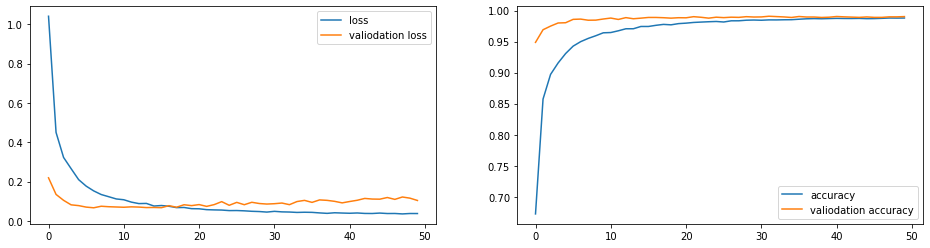

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='valiodation loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='valiodation accuracy')
axs[1].legend()

plt.show()

In [22]:
loaded_model = build_model()

In [23]:
loaded_model.load_weights('./new-model.h5')

## Validation

In [24]:
def predict(image: np.ndarray) -> str:
    prediction = loaded_model.predict(image)
    return TARGET_DECODER[np.argmax(prediction)]

In [25]:
def predict_many(images: np.ndarray):
    predictions = loaded_model.predict(images)
    return np.argmax(predictions, axis=1)

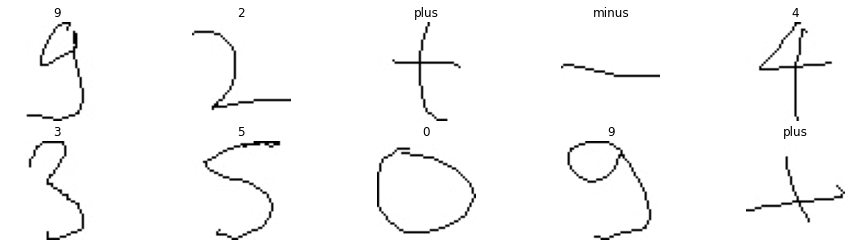

In [39]:
fig, axs = plt.subplots(2, 5, figsize=(16, 4))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        r = random.randint(0, len(x_test))
        img = x_test[np.newaxis, r, :]

        axs[i][j].imshow(img[0, :, :, 0], cmap='gray')
        axs[i][j].set_title(predict(img))
        axs[i][j].axis('off')

## Validation

In [27]:
predicts = predict_many(x_test)

In [41]:
TARGET_ENCODER.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'div', 'minus', 'parenthesis-closed', 'parenthesis-opened', 'plus', 'times'])

In [46]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       717
           1       0.96      0.90      0.93       783
           2       0.97      0.97      0.97       739
           3       1.00      0.98      0.99       738
           4       0.98      0.99      0.98       750
           5       0.98      1.00      0.99       716
           6       0.99      0.99      0.99       768
           7       1.00      0.99      0.99       738
           8       0.99      1.00      0.99       723
           9       0.98      0.99      0.99       763
          10       0.99      1.00      1.00       743
          11       1.00      0.99      1.00       781
          12       0.98      0.99      0.99       753
          13       0.94      0.97      0.96       744
          14       0.98      0.98      0.98       742
          15       0.99      1.00      1.00       761

    accuracy                           0.98     11959
   macro avg       0.98   

## Validation from outside

In [29]:
outside_image = get_image_from_file('../expressions/outside-expression-1.png')
outside_image = pre_processing(outside_image)

In [30]:
outside_image.shape

(45, 45, 1)

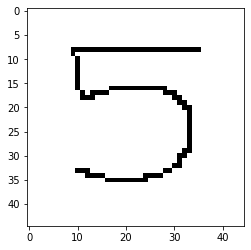

In [31]:
plt.imshow(outside_image[:, :], cmap='gray')

In [32]:
predict(outside_image[np.newaxis, :])

'5'